# IPO Exercise
Our investment banking division needs to improve the efficiency of our IPO (Initial Public
Offering) pricing recommendations. You've been asked to build a prototype model that
predicts whether a newly public company's stock will perform well (positive returns) in its
first quarter post-IPO.
## The Challenge
You will work with a dataset of historical IPO information and build a model to predict firstquarter
performance. This exercise evaluates your ability to:
- Perform exploratory data analysis
- Handle real-world financial data issues
- Build and evaluate appropriate ML models
- Communicate findings to non-technical stakeholders
## Dataset Description
You'll receive a CSV file (ipo_data.csv) with the following features:
## Company Metrics:
- company_age: Years since company founding
- employees: Number of employees at IPO
- revenue_millions: Annual revenue in millions USD
- revenue_growth_rate: YoY revenue growth percentage
- ebitda_margin: EBITDA margin percentage
- industry_sector: Tech, Healthcare, Finance, Consumer, Industrial, Energy
## IPO Characteristics:
- offer_price: Initial offering price per share
- shares_offered_millions: Number of shares offered
- underwriter_rank: Prestige ranking of lead underwriter (1-10)
- venture_backed: Binary indicator (0/1)
- lockup_period_days: Days until insiders can sell shares
## Market Conditions:
- market_volatility_index: VIX level at IPO date
- sector_performance_30d: Sector index performance prior 30 days (%)
- ipo_month: Month of IPO (1-12)
## Target Variable:
q1_return: First quarter stock return (%) - YOUR PREDICTION TARGET
- Binary classification: 1 if return > 0%, 0 otherwise
Dataset size: ~400 companies, ~20% missing values in some features

## Imports

In [1]:
import pandas as pd
import numpy as np
import calendar
import math


# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report, RocCurveDisplay)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plotting
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.subplots as sp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# random state
RANDOM_STATE = 42

## Dataset

In [2]:
# load the data or create it
try:
    df = pd.read("ipo_data.csv")
except:
    np.random.seed(RANDOM_STATE) 
    n_samples = 400
    # Generate synthetic IPO data
    data = { 
     'company_age': np.random.exponential(8, n_samples), 
     'employees': np.random.lognormal(6, 1.5, n_samples), 
     'revenue_millions': np.random.lognormal(4, 1.8, n_samples), 
     'revenue_growth_rate': np.random.normal(30, 25, n_samples), 
     'ebitda_margin': np.random.normal(-5, 15, n_samples), 
     'industry_sector': np.random.choice(['Tech', 'Healthcare', 'Finance', 'Consumer', 'Industrial', 'Energy'], 
    n_samples), 
     'offer_price': np.random.lognormal(2.5, 0.6, n_samples), 
     'shares_offered_millions': np.random.lognormal(2, 1, n_samples), 
     'underwriter_rank': np.random.randint(1, 11, n_samples), 
     'venture_backed': np.random.binomial(1, 0.6, n_samples), 
     'lockup_period_days': np.random.choice([90, 180, 270, 365], n_samples), 
     'market_volatility_index': np.random.normal(18, 6, n_samples), 
     'sector_performance_30d': np.random.normal(2, 8, n_samples), 
     'ipo_month': np.random.randint(1, 13, n_samples), 
    } 
    df = pd.DataFrame(data) 
    # Create target with some signal
    score = ( 
     df['revenue_growth_rate'] * 0.02 +
     df['underwriter_rank'] * 0.15 +
     df['venture_backed'] * 0.3 -
     df['market_volatility_index'] * 0.05 +
     df['sector_performance_30d'] * 0.08 +
     np.random.normal(0, 1, n_samples) 
    ) 
    df['q1_return'] = (score > score.median()).astype(int) 
    # Add missing values
    missing_mask = np.random.random(df.shape) < 0.1
    df = df.mask(missing_mask) 
    df.to_csv('ipo_data.csv', index=False) 
df.shape

(400, 15)

## Exploratory data analysis
### Datatypes

In [28]:
#summarise the df types
print(df.info())

# inspect unique list of following datatypes
inspect_list = ['q1_return','ipo_month','lockup_period_days','underwriter_rank','venture_backed']
print("\n" + "\n".join([f"{c} : -> {', '.join([str(x) for x in df[c].unique()])}" for c in inspect_list]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_age              361 non-null    float64
 1   employees                354 non-null    float64
 2   revenue_millions         362 non-null    float64
 3   revenue_growth_rate      363 non-null    float64
 4   ebitda_margin            362 non-null    float64
 5   industry_sector          353 non-null    object 
 6   offer_price              366 non-null    float64
 7   shares_offered_millions  362 non-null    float64
 8   underwriter_rank         352 non-null    float64
 9   venture_backed           356 non-null    float64
 10  lockup_period_days       372 non-null    float64
 11  market_volatility_index  371 non-null    float64
 12  sector_performance_30d   353 non-null    float64
 13  ipo_month                365 non-null    float64
 14  q1_return                3

#### Observations
- industry_sector -> categorical 
- target -> q1_return represented as binary float
- ipo_month -> represented as month number
- lockup_period_days -> small unique set
- underwriter_rank -> appears to be ranking from 1 to 10
- venture_backed -> binary float

### Inspect distributions

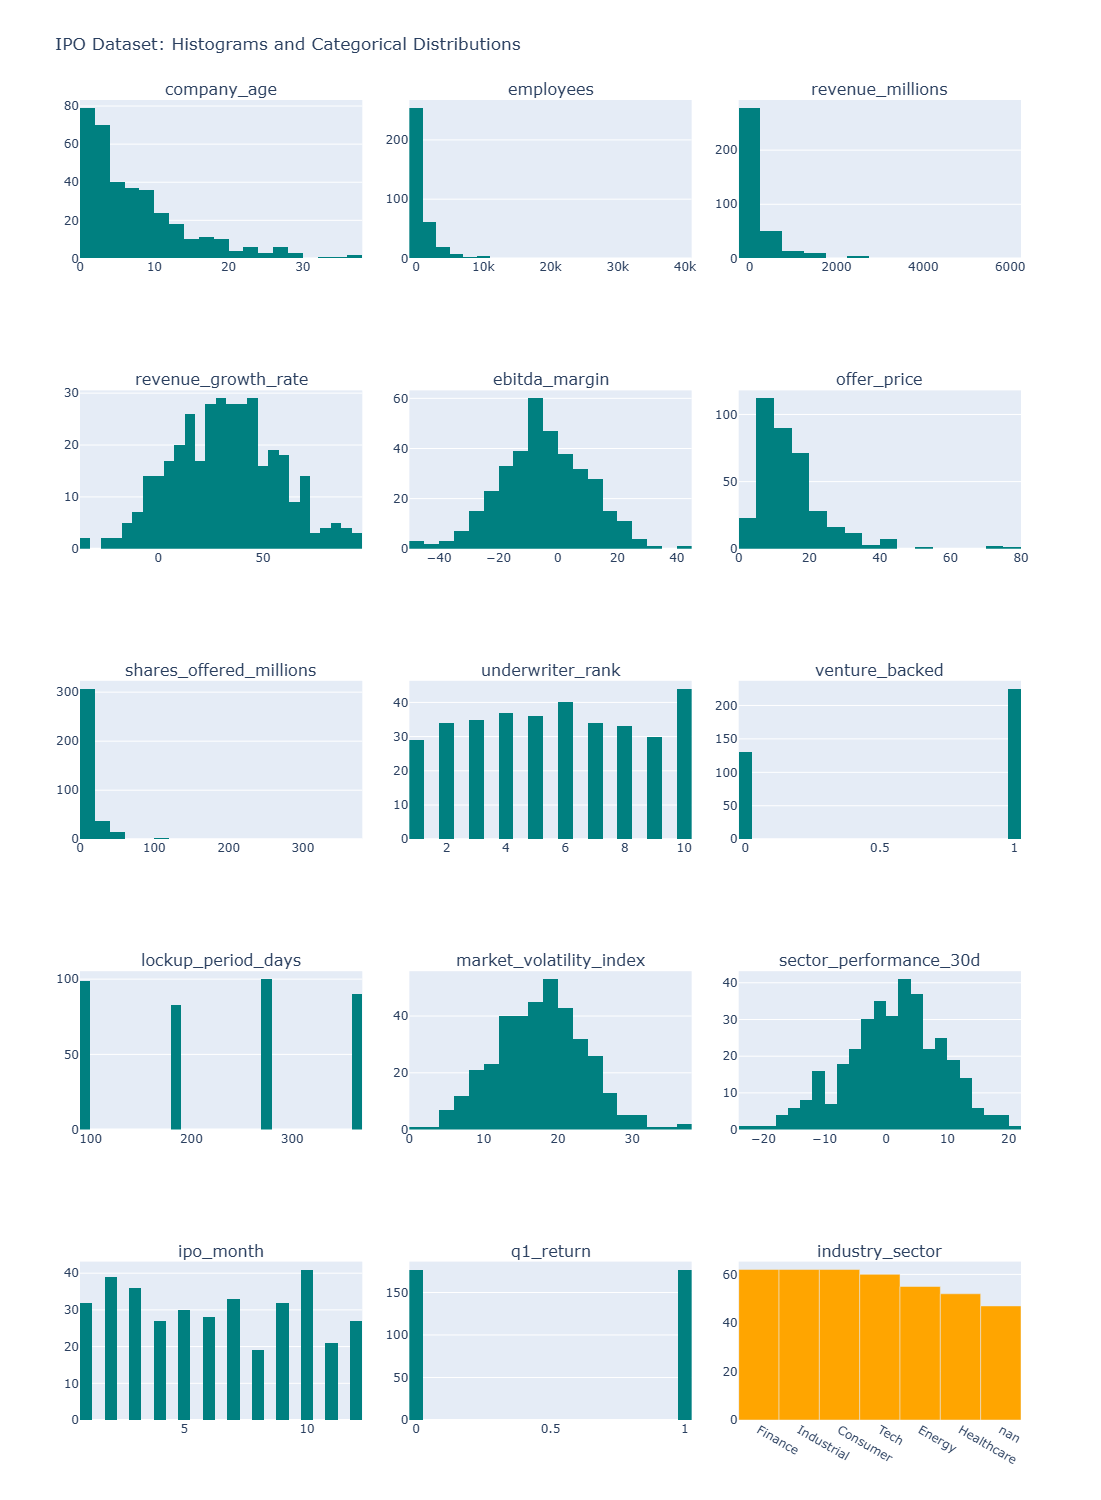

In [29]:
target = 'q1_return'
# Separate columns
numeric_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(exclude='number').columns.tolist()

# Total plots
all_cols = numeric_cols + categorical_cols
n_cols = 3
n_rows = math.ceil(len(all_cols) / n_cols)

# Create subplot grid
fig = make_subplots(rows=n_rows, cols=n_cols,
                    subplot_titles=all_cols,
                    horizontal_spacing=0.05, vertical_spacing=0.1)

# Add numeric histograms
for i, col in enumerate(numeric_cols):
    row = i // n_cols + 1
    col_pos = i % n_cols + 1
    fig.add_trace(
        go.Histogram(x=df[col], name=col, nbinsx=30, marker_color='teal'),
        row=row, col=col_pos
    )

# Add categorical bar charts
for j, col in enumerate(categorical_cols):
    idx = len(numeric_cols) + j
    row = idx // n_cols + 1
    col_pos = idx % n_cols + 1
    value_counts = df[col].value_counts(dropna=False)
    fig.add_trace(
        go.Bar(x=value_counts.index.astype(str), y=value_counts.values, name=col, marker_color='orange'),
        row=row, col=col_pos
    )

# Update layout
fig.update_layout(
    height=300 * n_rows,
    width=1000,
    title_text="IPO Dataset: Histograms and Categorical Distributions",
    showlegend=False
)

fig.show()


#### Observations
- heavily skewed datasets : company_age, employees, revenue_millions, offer_price, shares_offered_millions
    - these are related concepts of company size
    - suggestions to combine:
        - revenue_millions / employee
        - revenue_millions / company_age
        - share_offered_millions * offer_price
- volatility and sector performance are generally related but negatively correlated measures, used as market sentiment measures

## Missing data

In [5]:
# For info
print(f"to drop all rows with incomplete data remaing records would be: {len(df.dropna())} = {len(df.dropna()) / len(df):.0%}")


# Separate columns
numeric_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(exclude='number').columns

# Calculate missing proportions
missing_numeric = df[numeric_cols].isnull().mean().sort_values(ascending=False)
missing_categorical = df[categorical_cols].isnull().mean().sort_values(ascending=False)

# Create subplot grid: 1 row, 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=["Numeric Columns", "Categorical Columns"])

# Numeric bar chart
fig.add_trace(
    go.Bar(
        x=missing_numeric.index,
        y=(missing_numeric * 100).round(2),
        marker_color='teal',
        name='Numeric Missing %'
    ),
    row=1, col=1
)

# Categorical bar chart
fig.add_trace(
    go.Bar(
        x=missing_categorical.index,
        y=(missing_categorical * 100).round(2),
        marker_color='orange',
        name='Categorical Missing %'
    ),
    row=1, col=2
)

# Layout tweaks
fig.update_layout(
    height=500,
    width=1000,
    title_text="Missing Data Percentage by Column Type",
    showlegend=False
)
upper_range_num = math.ceil(missing_numeric.max()*10)*10
upper_range_cat = math.ceil(missing_categorical.max()*10)*10
fig.update_yaxes(title_text="Missing %", range=[0, upper_range_num], row=1, col=1)
fig.update_yaxes(title_text="Missing %", range=[0, upper_range_cat], row=1, col=2)

fig.show()


to drop all rows with incomplete data remaing records would be: 72 = 18%


#### Observations
- dropping all rows with missing data -> too extreme, only 72 records remaining
- dropping q1_return rows (the TARGET column) will still give us 88.25% of original rows - unavoidable
- approach is to impute missing data 

## Categorical analysis

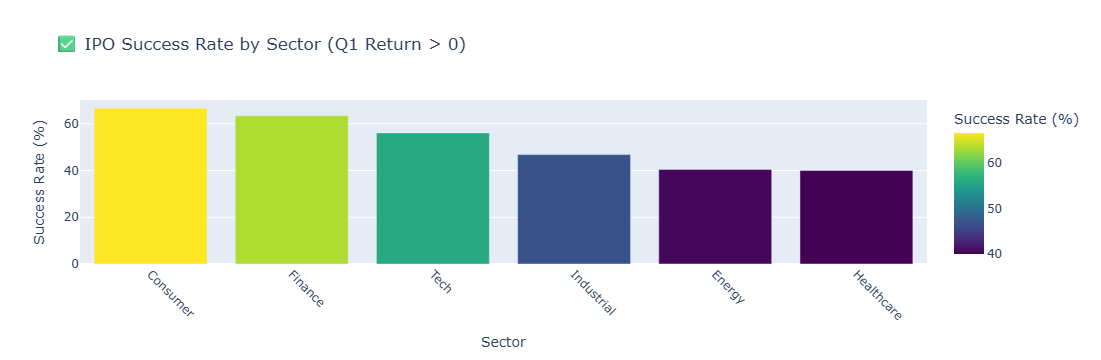

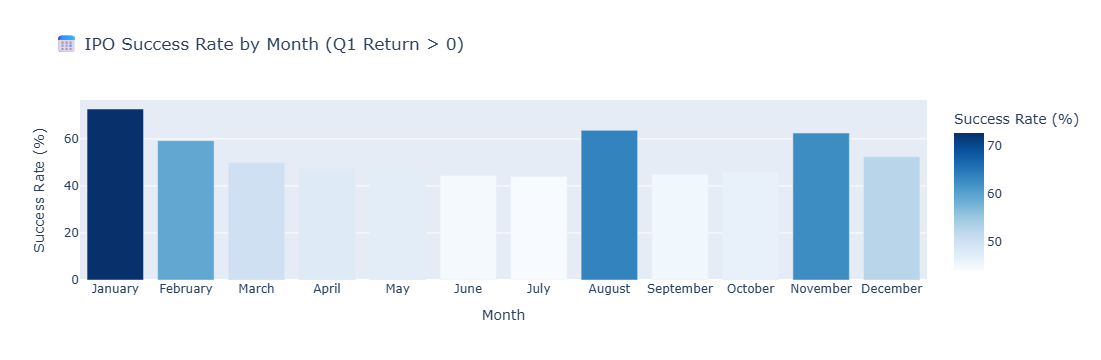

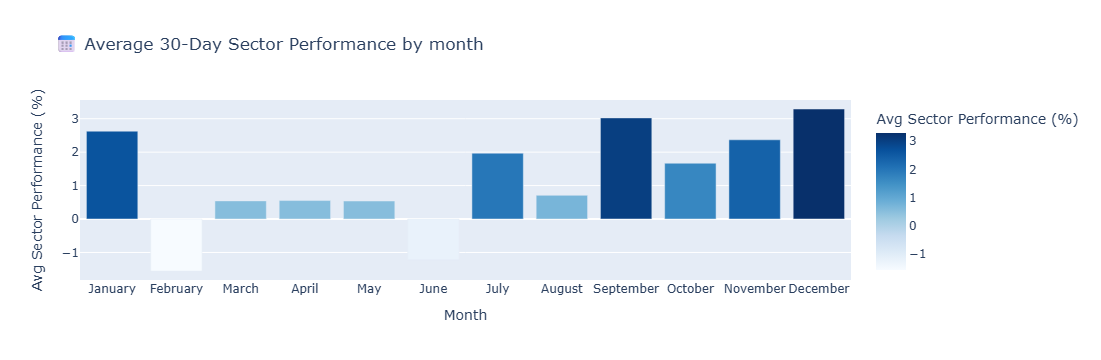

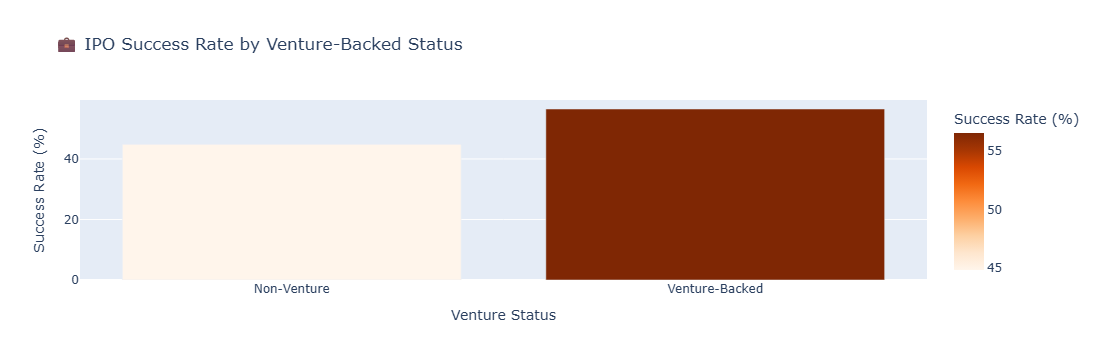

In [30]:
# Drop rows with missing q1_return, industry_sector, ipo_month, or venture_backed
df_filtered = df.dropna(subset=['q1_return', 'industry_sector', 'ipo_month', 'venture_backed']).copy()

# Define success as positive q1_return
df_filtered['successful'] = df_filtered['q1_return'] > 0

# --- Success rate by sector ---
sector_success = (
    df_filtered.groupby('industry_sector')['successful']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
sector_success['success_pct'] = (sector_success['successful'] * 100).round(2)

fig_sector = px.bar(
    sector_success,
    x='industry_sector',
    y='success_pct',
    title='✅ IPO Success Rate by Sector (Q1 Return > 0)',
    labels={'industry_sector': 'Sector', 'success_pct': 'Success Rate (%)'},
    color='success_pct',
    color_continuous_scale='Viridis'
)
fig_sector.update_layout(xaxis_tickangle=45)


# --- Success rate by IPO month (with month names) ---
df_filtered['ipo_month'] = df_filtered['ipo_month'].astype(int)
df_filtered['month_name'] = df_filtered['ipo_month'].apply(lambda x: calendar.month_name[x])

month_success = (
    df_filtered.groupby('month_name')['successful']
    .mean()
    .reset_index()
)
month_success['success_pct'] = (month_success['successful'] * 100).round(2)
month_success['month_order'] = month_success['month_name'].apply(lambda x: list(calendar.month_name).index(x))
month_success = month_success.sort_values('month_order')

fig_month = px.bar(
    month_success,
    x='month_name',
    y='success_pct',
    title='📅 IPO Success Rate by Month (Q1 Return > 0)',
    labels={'month_name': 'Month', 'success_pct': 'Success Rate (%)'},
    color='success_pct',
    color_continuous_scale='Blues'
)
fig_month.update_layout(xaxis_tickangle=0)


# --- Success rate by venture-backed status ---
df_filtered['venture_backed'] = df_filtered['venture_backed'].astype(int)
df_filtered['venture_label'] = df_filtered['venture_backed'].map({1: 'Venture-Backed', 0: 'Non-Venture'})

venture_success = (
    df_filtered.groupby('venture_label')['successful']
    .mean()
    .reset_index()
)
venture_success['success_pct'] = (venture_success['successful'] * 100).round(2)

fig_venture = px.bar(
    venture_success,
    x='venture_label',
    y='success_pct',
    title='💼 IPO Success Rate by Venture-Backed Status',
    labels={'venture_label': 'Venture Status', 'success_pct': 'Success Rate (%)'},
    color='success_pct',
    color_continuous_scale='Oranges'
)


# --- how does market perfomance look by month ---
# Drop rows with missing values in relevant columns
df_filtered = df.dropna(subset=['ipo_month', 'sector_performance_30d']).copy()

# Convert ipo_month to integer and map to month names
df_filtered['ipo_month'] = df_filtered['ipo_month'].astype(int)
df_filtered['month_name'] = df_filtered['ipo_month'].apply(lambda x: calendar.month_name[x])

# Group by month and calculate average 30-day sector performance
monthly_avg = (
    df_filtered.groupby('month_name')['sector_performance_30d']
    .mean()
    .reset_index()
)

# Preserve calendar order
monthly_avg['month_order'] = monthly_avg['month_name'].apply(lambda x: list(calendar.month_name).index(x))
monthly_avg = monthly_avg.sort_values('month_order')

# Plot bar chart
fig_perf = px.bar(
    monthly_avg,
    x='month_name',
    y='sector_performance_30d',
    title='📅 Average 30-Day Sector Performance by month',
    labels={'month_name': 'Month', 'sector_performance_30d': 'Avg Sector Performance (%)'},
    color='sector_performance_30d',
    color_continuous_scale='Blues'
)

fig_perf.update_layout(xaxis_tickangle=0)

fig_sector.show()
fig_month.show()
fig_perf.show()
fig_venture.show()

#### Observations
- Consumer and Financials are best performers
- Best months are January, August, November
- Venture backing outperforms
- Sector performance by month roughly matches ipo performance

## Features
### Define

In [7]:
def pre_processing(df):
    df1 = df.dropna(subset=['q1_return']).copy()

    
    # Create derived features
    df1['revenue_per_employee'] = df1['revenue_millions'] / df1['employees']
    df1['market_value'] = df1['offer_price'] * df1['shares_offered_millions'] # could have infuence if it gets added into indices

    
    # Log-transform skewed features
    skewed_cols = [
        'company_age', 'employees', 'revenue_millions',
        'offer_price', 'shares_offered_millions',
        'revenue_per_employee','market_value'
    ]
    for col in skewed_cols:
        df1[f"log_{col}"] = np.log1p(df1[col])

    # drop skewed features
    df1 = df1.drop(skewed_cols, axis=1)
    return df1


### Review

In [8]:
df_input = pre_processing(df)

# Select numeric columns
numeric_cols = df_input.select_dtypes(include='number').columns

# Create subplot grid
rows = int(np.ceil(len(numeric_cols) / 3))
fig = sp.make_subplots(rows=rows, cols=3, subplot_titles=numeric_cols)

# Add histograms
for i, col in enumerate(numeric_cols):
    r, c = divmod(i, 3)
    fig.add_trace(
        go.Histogram(x=df_input[col], name=col, nbinsx=40),
        row=r+1, col=c+1
    )

fig.update_layout(
    title_text="📊 Histograms of Transformed IPO Dataset",
    height=300 * rows,
    showlegend=False
)
fig.show()


#### Observations
- new features look skewed too so log has been applied

## Pipeline

In [21]:
# Separate features and target
X = df_input.drop(target, axis=1)
y = df_input[target]


# Identify column types
numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(exclude='number').columns.tolist()

# override categoricals
if True:
    # categorical features
    categorical_features = ['industry_sector', 'lockup_period_days', 'venture_backed','ipo_month'] # ipo_months could pick optimal launch
    
    # update numerical features (excl. cat features)
    numeric_features = [n for n in numeric_features if n not in categorical_features]


# Preprocessing transformers
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor1 = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE) ## set to default, , test_size=0.2

# random forest pipeline
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor1),
    ('regressor', RandomForestClassifier(random_state=42))
    # ('regressor', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)

# logistic regression pipeline
logreg_pipeline = Pipeline([
    ('preprocessing', preprocessor1),
    ('classifier', LogisticRegression(random_state = 42)) #max_iter=1000
])
logreg_pipeline.fit(X_train, y_train);


## Evaluation

Logistic Regression:
Accuracy: 0.797752808988764
ROC AUC: 0.8437815975733064
Precision: 0.7906976744186046
Recall: 0.7906976744186046
F1: 0.7906976744186046

              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80        46
         1.0       0.79      0.79      0.79        43

    accuracy                           0.80        89
   macro avg       0.80      0.80      0.80        89
weighted avg       0.80      0.80      0.80        89



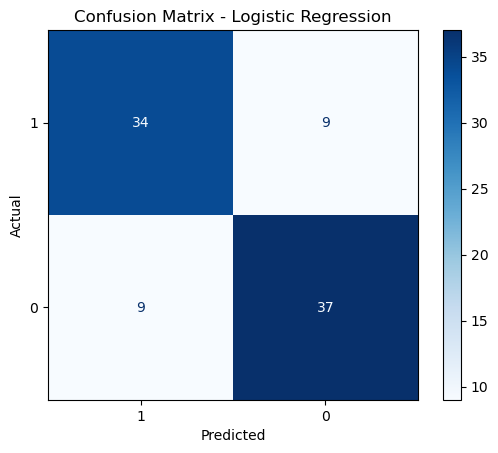

Random Forest:
Accuracy: 0.7865168539325843
ROC AUC: 0.8670374115267948
Precision: 0.8333333333333334
Recall: 0.6976744186046512
F1: 0.759493670886076

              precision    recall  f1-score   support

         0.0       0.75      0.87      0.81        46
         1.0       0.83      0.70      0.76        43

    accuracy                           0.79        89
   macro avg       0.79      0.78      0.78        89
weighted avg       0.79      0.79      0.78        89



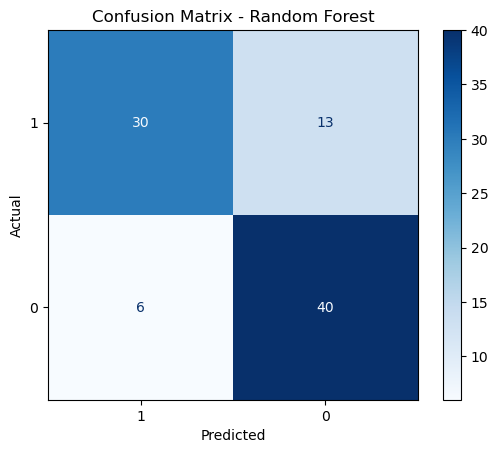

In [22]:
def evaluate(pipe, X_test, y_test, model_name):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] # get the positive return class only
    
    print(f"{model_name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print()
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
    disp.plot(cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

evaluate(logreg_pipeline, X_test, y_test, "Logistic Regression")
evaluate(rf_pipeline, X_test, y_test, "Random Forest")

## ROC / AUC curve

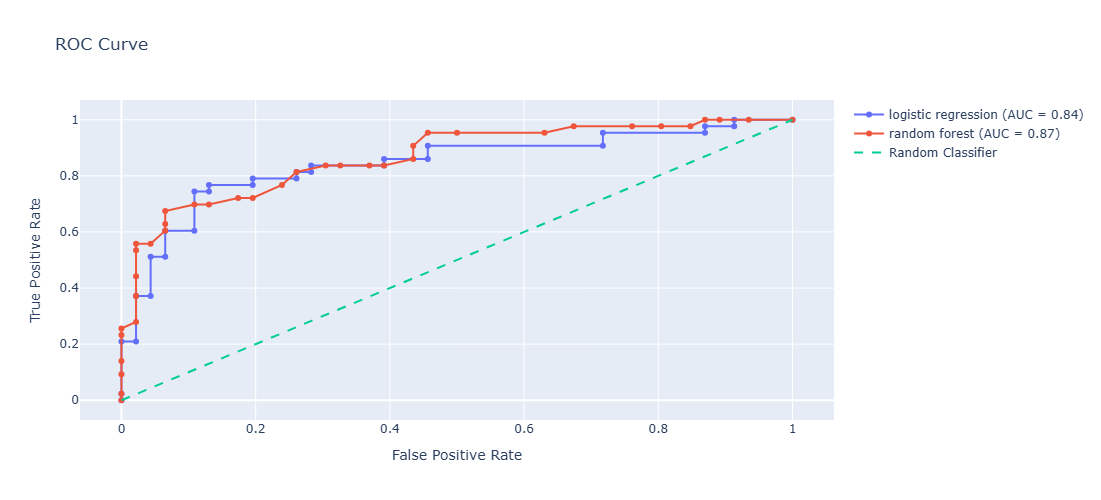

In [23]:
y_pred_proba_log = logreg_pipeline.predict_proba(X_test)[:,1] # get the positive return class only
y_pred_proba_rfc = rf_pipeline.predict_proba(X_test)[:,1] # get the positive return class only

# Compute ROC curve and AUC
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log)
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_pred_proba_rfc)

auc_log = roc_auc_score(y_test, y_pred_proba_log)
auc_rfc = roc_auc_score(y_test, y_pred_proba_rfc)

# create plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr_log, y=tpr_log, mode='lines+markers', name=f'logistic regression (AUC = {auc_log:.2f})'))
fig.add_trace(go.Scatter(x=fpr_rfc, y=tpr_rfc, mode='lines+markers', name=f'random forest (AUC = {auc_rfc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier', line=dict(dash='dash')))
fig.update_layout(
    title='ROC Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=700,
    height=500
)
fig.show()

### Observations
- Random Forest outperformances overall on ROC AUC

## Model comparison

In [24]:
# use cross validate
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = ['accuracy','roc_auc','precision','recall','f1']
cv_lr = cross_validate(logreg_pipeline, X, y, cv=skf, scoring=scoring, return_train_score=True)
cv_rf = cross_validate(rf_pipeline, X, y, cv=skf, scoring=scoring, return_train_score=True)
df_rf = pd.DataFrame(cv_rf).mean().to_frame().rename(columns={0:'Random Forest'})
df_lr = pd.DataFrame(cv_lr).mean().to_frame().rename(columns={0:'Logistic Regression'})
df_lr.join(df_rf).style.format("{:.0%}")

,Logistic Regression,Random Forest
fit_time,2%,16%
score_time,2%,3%
test_accuracy,74%,67%
train_accuracy,81%,100%
test_roc_auc,83%,76%
train_roc_auc,89%,100%
test_precision,75%,67%
train_precision,81%,100%
test_recall,75%,66%
train_recall,81%,100%


### Observations
- Random Forest overfits: train_accuracy, recall is 100%, but test_accuracy, test_recall is significantly lower
- Logistic outperforms on all test accuracy, recall, f1
- Fitting times not relevant for dataset of this size

## Feature importance

### Logistic Regression

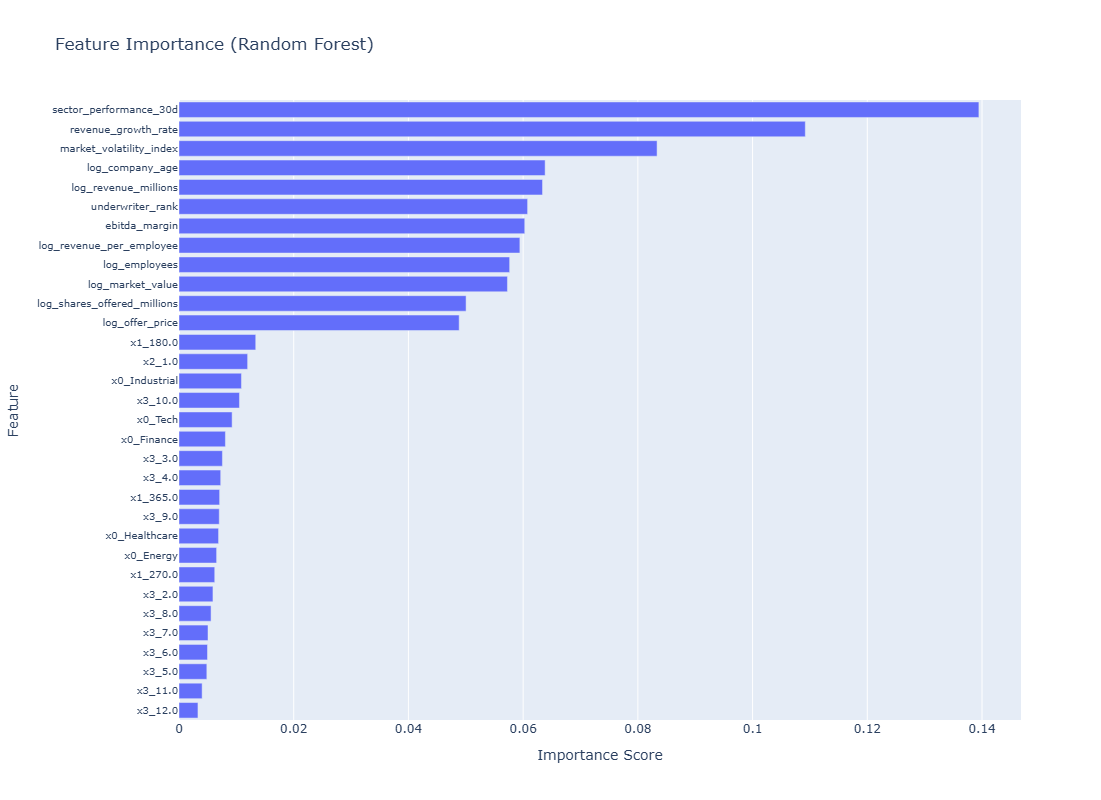

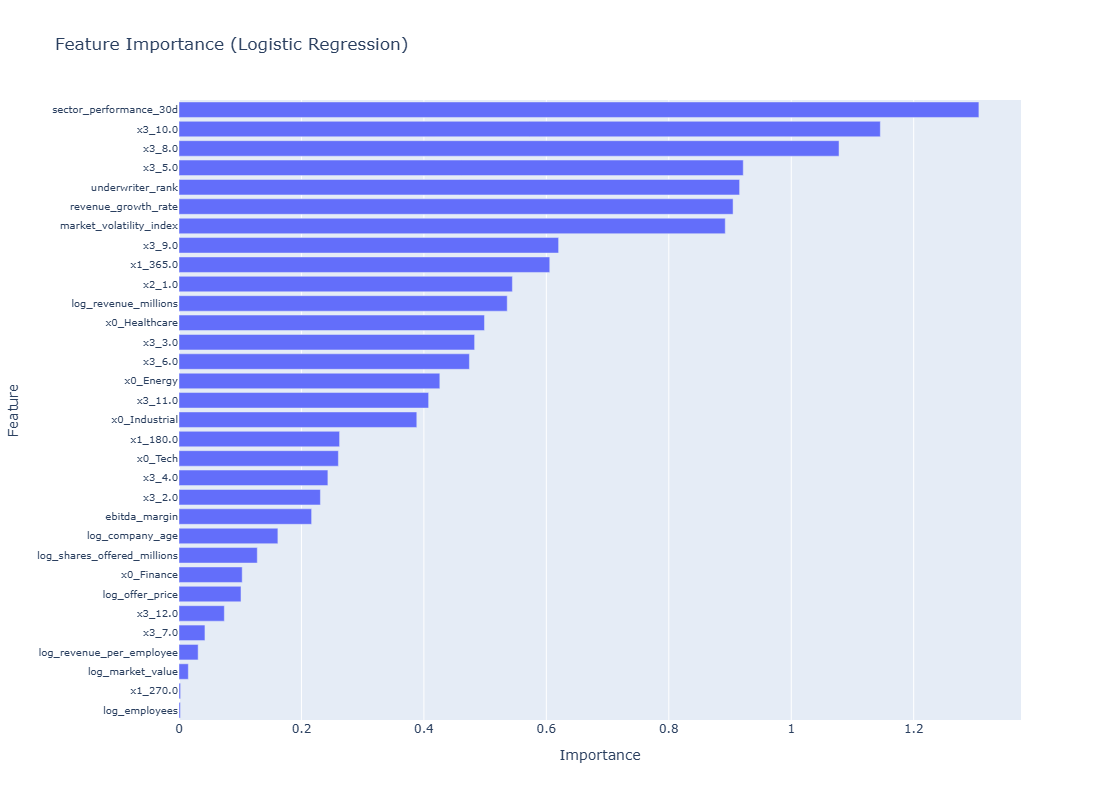

In [25]:
#### Logistic Regression Classifier ###

# get numeric names
num_cols_after = numeric_features
# get onehot names
ohe = preprocessor1.named_transformers_['cat'].named_steps['encoder']
ohe_cols = list(ohe.get_feature_names_out())
feature_names = num_cols_after + ohe_cols

coefs = logreg_pipeline.named_steps['classifier'].coef_[0] # get feature coefficients
df_coef = pd.DataFrame({'feature': feature_names, 'coef': coefs}).sort_values(by='coef', key=abs, ascending=True)
df_coef['abs_coef'] = df_coef['coef'].abs()
fig_lr = px.bar(
    df_coef,
    x='abs_coef',
    y='feature',
    orientation='h',
    title='Feature Importance (Logistic Regression)',
    labels={'abs_coef': 'Importance', 'feature': 'Feature'},
    height=800
)

fig_lr.update_layout(yaxis=dict(tickfont=dict(size=10)));

#### Random Forest Classifier ####
importances = rf_pipeline.named_steps['regressor'].feature_importances_ # feature importances
df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=True)

fig_rf = px.bar(
    df_imp,
    x='importance',
    y='feature',
    orientation='h',
    title='Feature Importance (Random Forest)',
    labels={'importance': 'Importance Score', 'feature': 'Feature'},
    height=800
)
fig_rf.update_layout(yaxis=dict(tickfont=dict(size=10)));

fig_rf.show()
fig_lr.show()

#### Observations
- top features are market timing related, volatility and sector performance, good market conditions and timing are key
- in fundamental terms, revenue_growth rate more important than ebitda margin, the proxy for profitability, intuitively ipo investors are looking for growth

## ✨ Executive Summary

### 🔍 Key Findings

- **Market timing is critical**: Logistic regression highlights August, October, and May as optimal IPO months. A strong inverse relationship between market volatility and IPO success underscores the importance of launching in stable markets.
- **Revenue growth trumps profitability**: Investors favor high-growth stories over immediate profitability. Revenue growth acts as a multiplier in favorable markets, while EBITDA margin plays a secondary role.
- **Underwriter quality matters**: Top-tier underwriters are consistently associated with better IPO outcomes—quality over cost.
- **Longer lock-up periods send positive signals**: Extended lock-ups may indicate insider confidence, aligning with investor expectations.

### 📊 Model Performance Summary

- **Logistic regression outperforms**: It balances predictive power with interpretability and avoids overfitting.
- **Random Forest underperforms**: Despite its complexity, it fails to generalise well and offers no insight into IPO month effects—unlike logistic regression.

### 💼 Business Recommendations

- **Adopt logistic regression** as the primary modeling tool for IPO success prediction.
- **Prioritize market conditions and timing**: Delay IPOs in volatile or bearish markets; capitalise on favorable windows.
- **Emphasize growth metrics**: Position revenue growth as the central narrative in investor communications.
- **Select reputable underwriters** and consider longer lock-up periods to boost investor confidence.

### 🌟 Top Predictive Features

| Feature Category | Key Drivers Identified |
|------------------|------------------------|
| **Timing**       | 30-day market performance, IPO month (Aug, Oct, May) |
| **Financials**   | Revenue growth (preferred over EBITDA margin) |
| **Reputation**   | Underwriter quality |
| **Signal Strength** | Lock-up duration |

### 🔄 Next Steps

- **Expand the dataset**: Incorporate a broader historical sample to improve generalisation.
- **Explore additional variables**: Include exchange-specific effects and capital raised vs. total capital offered, exchange listing choices. 

### ⚠️ Limitations

- **Sample size**: Current dataset may not capture full market variability.
- **Exchange choice**: Not yet accounted for; a key choice for an IPO is where you list.
- **Feature scope**: Further variables like investor sentiment, and macroeconomic indicators could enhance model robustness.


In [14]:
# !pip freeze > requirements.txt